In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import svm, neighbors, tree, ensemble, model_selection, metrics
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

sns.set_theme()

In [5]:
data_folder = "data/traces/"

def read_date(date: str):
    """Aggregate data of a single from parts"""
    data = pd.DataFrame()

    for i in range(50):
        try:
            frame = pd.read_csv(data_folder + date + "-{}.csv".format(i))
            data = pd.concat([data, frame], axis=0)
        except OSError:
            pass

    return data


def read_date_part(date_part: str):
    """Read data of a part of a capture date"""
    data = pd.DataFrame()

    try:
        frame = pd.read_csv(data_folder + date_part + ".csv")
        data = pd.concat([data, frame], axis=0)
    except OSError:
        pass

    return data

data = read_date_part("16-09-23")
data.set_index("timestamp")
print(data)

       packet_id            timestamp  packet_size            eth_src   
0              0  1474552802257569024           70  18:b7:9e:02:20:44  \
1              1  1474552802257692160           66  18:b7:9e:02:20:44   
2              2  1474552802323085056           66  14:cc:20:51:33:ea   
3              3  1474552802383173888           60  d0:52:a8:00:67:5e   
4              5  1474552802447910912           88  70:ee:50:18:34:43   
...          ...                  ...          ...                ...   
46193      49996  1474560343348738048           66  14:cc:20:51:33:ea   
46194      49997  1474560343487133952           66  18:b7:9e:02:20:44   
46195      49998  1474560343508438016           42  ec:1a:59:83:28:11   
46196      49999  1474560343508498944           42  14:cc:20:51:33:ea   
46197      50000  1474560343931791104          156  30:8c:fb:2f:e4:b2   

       device_name protocol    iot  
0              NaN      Raw  False  
1              NaN      TCP  False  
2           

In [6]:
def attach_window_id(timestamped_frame: pd.DataFrame) -> list[pd.DataFrame]:
    """Slice the dataframe into 1-second intervals"""
    first_packet_time = timestamped_frame.iloc[0]['timestamp']
    last_packet_time = timestamped_frame.iloc[-1]['timestamp']
    windowed_frame = timestamped_frame.set_index('timestamp', drop=False) 

    ns_in_sec = int(1e9)
    number_of_windows = int((last_packet_time - first_packet_time) / ns_in_sec) + 1

    try:
        windowed_frame.insert(0, value=0, column="window_id")
    except Exception as e:
        print("It seems like the column 'window_id' already exists. Just updating values...")
        print(e)
    finally:
        windowed_frame.window_id.astype(np.int64)

    for window_id in range(0, number_of_windows):
        from_time = first_packet_time + window_id * ns_in_sec
        to_time = first_packet_time + (window_id  + 1) * ns_in_sec
        windowed_frame.loc[from_time:to_time, 'window_id'] = window_id
    
    windowed_frame.set_index('window_id', inplace=True)
    return windowed_frame


devices = pd.read_csv("data/list_of_devices.csv")
windowed_frame = attach_window_id(data)
print(windowed_frame)

           packet_id            timestamp  packet_size            eth_src   
window_id                                                                   
0                  0  1474552802257569024           70  18:b7:9e:02:20:44  \
0                  1  1474552802257692160           66  18:b7:9e:02:20:44   
0                  2  1474552802323085056           66  14:cc:20:51:33:ea   
0                  3  1474552802383173888           60  d0:52:a8:00:67:5e   
0                  5  1474552802447910912           88  70:ee:50:18:34:43   
...              ...                  ...          ...                ...   
7541           49996  1474560343348738048           66  14:cc:20:51:33:ea   
7541           49997  1474560343487133952           66  18:b7:9e:02:20:44   
7541           49998  1474560343508438016           42  ec:1a:59:83:28:11   
7541           49999  1474560343508498944           42  14:cc:20:51:33:ea   
7541           50000  1474560343931791104          156  30:8c:fb:2f:e4:b2   

In [7]:
def generate_features_labeled(windowed_frame: pd.DataFrame, device_frame: pd.DataFrame):
    """Calculate the mode, mean, and median of a window"""
    features = pd.DataFrame()

    for device_index in device_frame.index:
        device = device_frame.iloc[device_index]
        device_packets = windowed_frame.loc[windowed_frame['eth_src'] == device['eth_src']]
        device_features = generate_features(device_packets)

        device_features.insert(len(device_features.columns), "device_name", device['device_name'])
        device_features.insert(len(device_features.columns), "iot", device['iot'])

        features = pd.concat([features, device_features])

    features.columns = ["window_id", "mean", "std", "n_bytes", "device_name", "iot"]
    features.set_index("window_id", inplace=True)

    return features

def generate_features(windowed_frame: pd.DataFrame):
    features =  pd.DataFrame()

    for window_id in windowed_frame.index.unique():
        packet_sizes = windowed_frame.loc[window_id, 'packet_size']

        mean = packet_sizes.mean()
        std = packet_sizes.std()
        n_bytes = packet_sizes.sum()

        features = pd.concat([features, pd.DataFrame([[window_id, mean, std, n_bytes]])], axis=0)

    return features

def get_devices_in_window(windowed_frame: pd.DataFrame):
    devices_in_window = pd.DataFrame()
    
    for window_id in windowed_frame.index.unique():
        devices = windowed_frame.loc[window_id]['device_name']
        # iot = windowed_frame.loc[window_id]['iot']

        if not isinstance(devices, str):
            devices = devices.unique() 
            
        devices_in_window = pd.concat([devices_in_window, pd.DataFrame({"window_id": window_id, "devices": devices})])

    return devices_in_window

labeled_features = generate_features_labeled(windowed_frame, devices)

In [43]:
from enum import StrEnum

class Balancing(StrEnum):
    NONE = "none"
    STRATIFIED = "stratified"
    OVER_UNDER = "over_under"
    OVER_UNDER_RUS = "over_under_rus"

def _balance_over_under(X, y, rus=False, random_state: int | None = None):
    oversampling = SMOTE(random_state=random_state)

    # Resource [32] is actually really old (2009), NearMiss is a better alternative than RUS
    # but I left it as an option
    if rus:
        undersampling = RandomUnderSampler(random_state=random_state)
    else:
        undersampling = NearMiss()

    # first oversample, then undersample
    X, y = oversampling.fit_resample(X, y)
    X, y = undersampling.fit_resample(X, y)

    return X, y

def _get_models():
    models = {
        "Knn" : neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
        "DT"  : tree.DecisionTreeClassifier(),
        "RF"  : ensemble.RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
        # "SVM" : svm.SVC(),
    }
    params = {
        "Knn" : 
            {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 30, 40, 100], 'weights' : ["distance", "uniform"]},
        "DT" : {},
        "RF" : {},
    }
    # I don't really see the advantage of using an ensemble balancing method in conjuction with the
    # under- and oversample techniques. I can't find any indication in the paper the referenced [32]
    # that it actually works. So, I'm just keeping this here.
    models["Majority Voting"] = ensemble.VotingClassifier
    params["Majority Voting"] = {'voting' : ['hard', 'soft']}

    return models, params

def _using_kfold(n_splits):
    return n_splits > 1

def _evaluate(model, model_name: str, accuracy: int, target_label: str, balancing: Balancing, scores={}):
    if len(scores.keys()) == 0:
        scores = {"model" : [], "accuracy" : [], "label" : [], "balancing" : []}

    scores["model"].append(model_name)
    scores["accuracy"].append(accuracy)
    scores["label"].append(target_label)
    scores["balancing"].append(balancing)

    return scores

def _custom_tuner(X_train, y_train, balancing=Balancing.NONE, target_label=None, n_splits=10, n_jobs=-1):
    if n_splits == 1:
        print("Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.")
        n_splits = 10
    if balancing == Balancing.STRATIFIED:
        print("Warning: Stratified learning with hyper parameter tuning is effectively Balancing.NONE")
        
    models, params = _get_models()
    scores = {}
    trained = {}

    for (name, model) in models.items():
        if name == "Majority Voting":
            model = model(list(trained.items()))

        tuning = model_selection.GridSearchCV(
                model, 
                params[name], 
                scoring = "accuracy", 
                cv=n_splits,
                n_jobs=n_jobs
            )
        tuning.fit(X_train, y_train)
        trained[name] = tuning.best_estimator_
        scores = _evaluate(trained[name], name, tuning.best_score_, target_label=target_label, balancing=balancing, scores=scores)

    return trained, pd.DataFrame(scores)


def _custom_kfold(X_train, y_train, target_label=None, balancing=Balancing.NONE, kf=None):
    models, _ = _get_models()
    scores = {}
    trained = {}

    if kf is not None:
        folds = [ (X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]) for (train, test) in kf.split(X_train, y_train) ]
    else:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train)
        folds = [ (X_train, X_test, y_train, y_test) ]
    
    for (name, model) in models.items():
        if name == "Majority Voting":
            model = model(list(trained.items()))

        for (X_train, X_test, y_train, y_test) in folds:
            trained[name] = model.fit(X_train, y_train)
            accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
            scores = _evaluate(model, name, accuracy, target_label, balancing, scores=scores)

    return trained, pd.DataFrame(scores)

def train_and_test_classifiers(labeled_features, target_label, balancing=Balancing.NONE, n_splits=10, shuffle=False, random_state=None, tuned=False):
    """
    Trains and tests a series of models on the given, labeled data
    (Knn, RF, DT, SVM, Majority Voting)

    When n_splits < 2, KFold is not used and the test set has a size of 25% of the whole dataset
    """
    assert not (balancing == Balancing.STRATIFIED and not _using_kfold(n_splits)) # KFold cannot be disabled if using the stratified balancing strategy
    
    # If there is no balancing, we condsider the original dataset to be balanced
    # thus, it is balanced by default
    X_bal = labeled_features.iloc[:, 1:3]
    y_bal = labeled_features.iloc[:][target_label]
    X_ubal = None
    y_ubal = None

    kf = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) if _using_kfold(n_splits) else None

    # If we're balancing the data itself, we should keep an unbalanced set (ubal) as testing set
    if balancing != Balancing.NONE:
        X_bal, X_ubal, y_bal, y_ubal = model_selection.train_test_split(X_bal, y_bal, test_size=.1)

    if balancing == Balancing.OVER_UNDER:
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=random_state)
    if balancing == Balancing.OVER_UNDER_RUS:
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, rus=True, random_state=random_state)
    if balancing == Balancing.STRATIFIED:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    if tuned:
        trained, scores_bal = _custom_tuner(X_bal, y_bal, n_splits=n_splits, balancing=balancing, target_label=target_label)
    else:
        trained, scores_bal = _custom_kfold(X_bal, y_bal, kf=kf, balancing=balancing, target_label=target_label) 

    # If we haven't done balancing, the scores are good as they are
    if balancing == Balancing.NONE:
        return trained, scores_bal

    # Otherwise, we should test on the unbalanced datasets
    scores_ubal = {}
    for (name, model) in trained.items():
        accuracy = metrics.accuracy_score(y_ubal, model.predict(X_ubal))
        scores_ubal = _evaluate(model, name, accuracy, target_label, balancing, scores=scores_ubal)

    return trained, pd.DataFrame(scores_ubal)

def run_all_experiments(labeled_features, trainer):
    # for the device classifier, we only consider iot devices
    device_features = labeled_features.loc[labeled_features['iot'] == True]

    # Balancing as done in the paper
    iot_classfiers, iot_scores = trainer(labeled_features, 'iot', balancing=Balancing.OVER_UNDER_RUS, n_splits=1)
    device_classifier, device_scores = trainer(device_features, 'device_name', balancing=Balancing.STRATIFIED)

    # Balancing strategies reversed
    iot_classfiers_diff, iot_scores_diff = trainer(labeled_features, 'iot', balancing=Balancing.STRATIFIED)
    device_classifier_diff, device_scores_diff = trainer(device_features, 'device_name', balancing=Balancing.OVER_UNDER_RUS, n_splits=1)

    # Balancing without RUS (with NearMiss)
    iot_classfiers_nm, iot_scores_nm = trainer(labeled_features, 'iot', balancing=Balancing.OVER_UNDER, n_splits=1)
    device_classfiers_nm, device_scores_nm = trainer(device_features, 'device_name', balancing=Balancing.OVER_UNDER, n_splits=1)

    # No balancing for either
    iot_classfiers_unb, iot_scores_unb = trainer(labeled_features, 'iot', balancing=Balancing.NONE)
    device_classifier_unb, device_scores_unb = trainer(device_features, 'device_name', balancing=Balancing.NONE)

    return pd.concat([iot_scores, device_scores, iot_scores_unb, device_scores_unb, iot_scores_diff, device_scores_diff, iot_scores_nm, device_scores_nm])

all_scores = run_all_experiments(labeled_features, train_and_test_classifiers)
all_scores_tuned = run_all_experiments(labeled_features, 
                                       lambda *params, **named : train_and_test_classifiers(*params, **named, tuned=True))

all_scores.groupby(["model", "label", "balancing"]).mean()
all_scores_tuned.groupby(["model", "label", "balancing"]).mean()

Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.
Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.
Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.
Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.


accuracy
model           label       balancing               
DT              device_name over_under      0.795077
                            over_under_rus  0.795077
                            stratified      0.819694
                iot         over_under      0.878060
                            over_under_rus  0.863818
                            stratified      0.875834
                none        none            0.831899
Knn             device_name over_under      0.723220
                            over_under_rus  0.709248
                            stratified      0.818363
                iot         over_under      0.758344
                            over_under_rus  0.762350
                            stratified      0.875389
                none        none            0.768237
Majority Voting device_name over_under      0.796407
                            over_under_rus  0.794411
                            stratified      0.820359
                iot         over_under      0.877170
                            over_under_rus  0.865599
                            stratified      0.878505
                none        none            0.826745
RF              device_name over_under      0.797738
                            over_under_rus  0.794411
                            stratified      0.821690
                iot         over_under      0.880285
                            over_under_rus  0.865599
                            stratified      0.879840
                none        none            0.828580

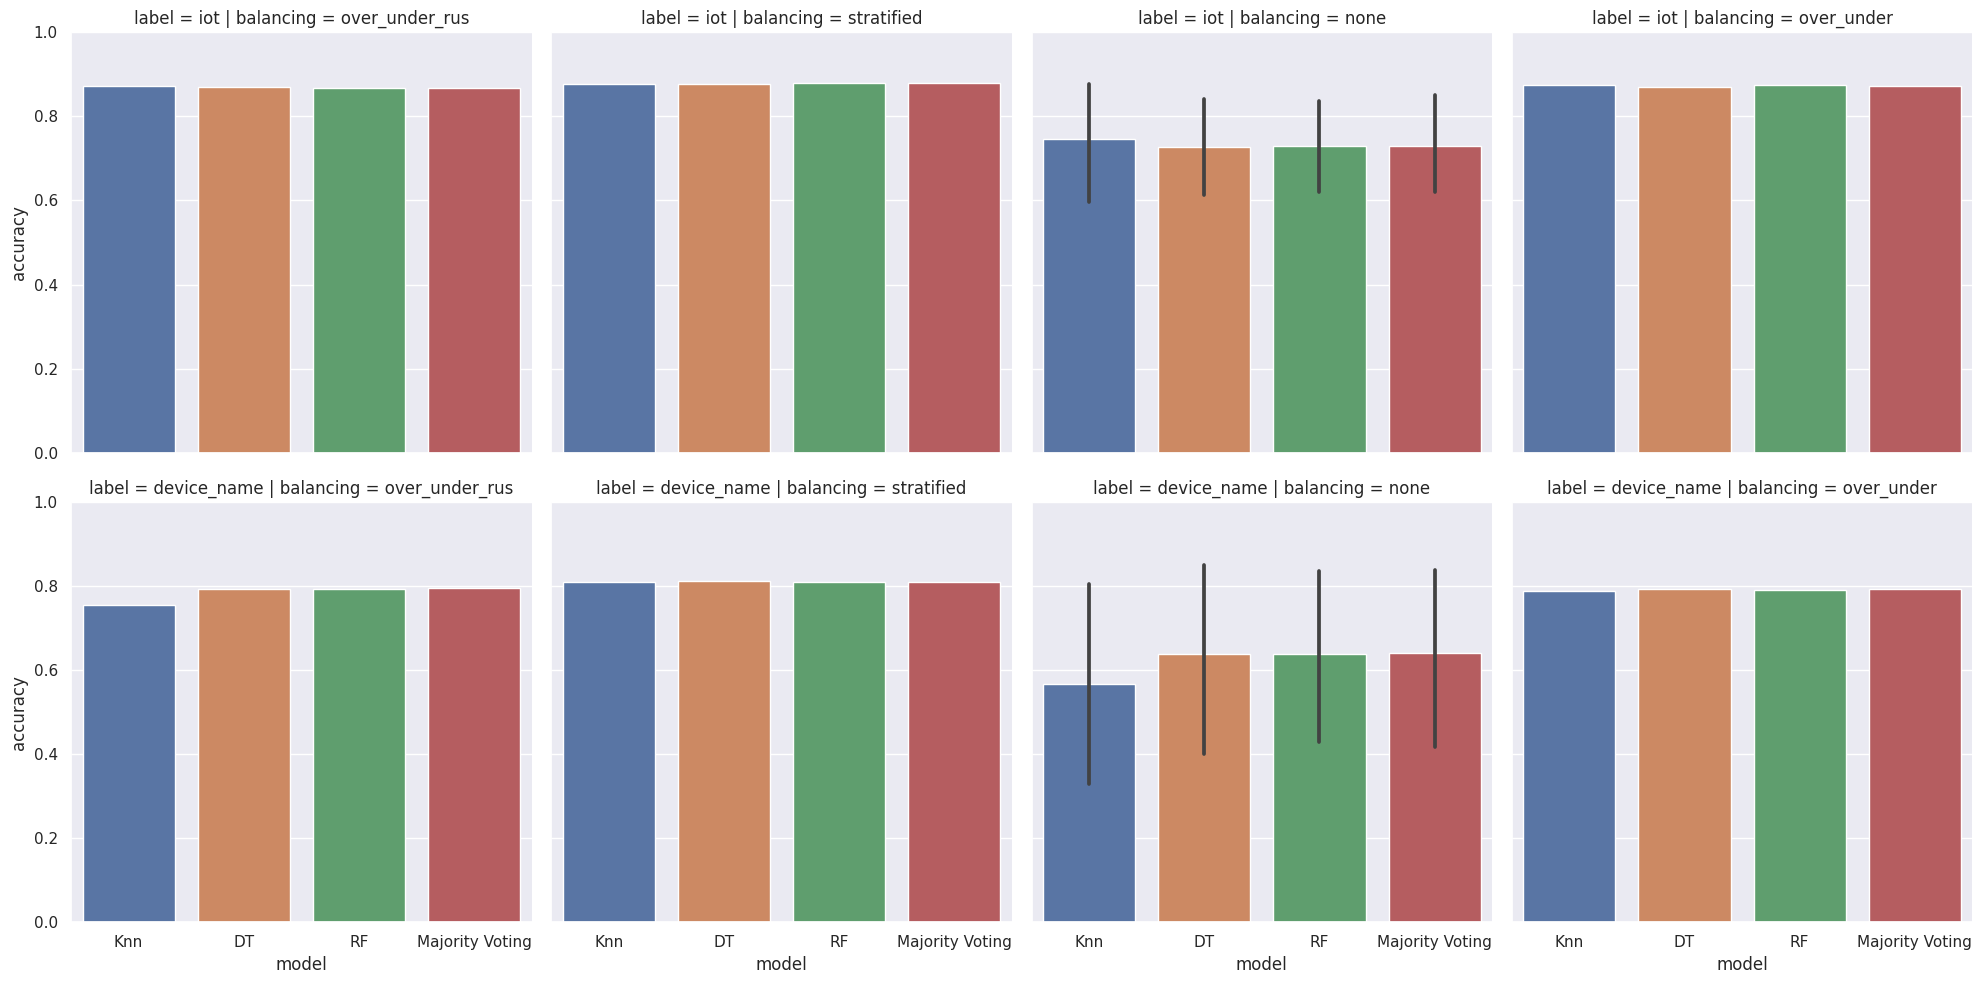

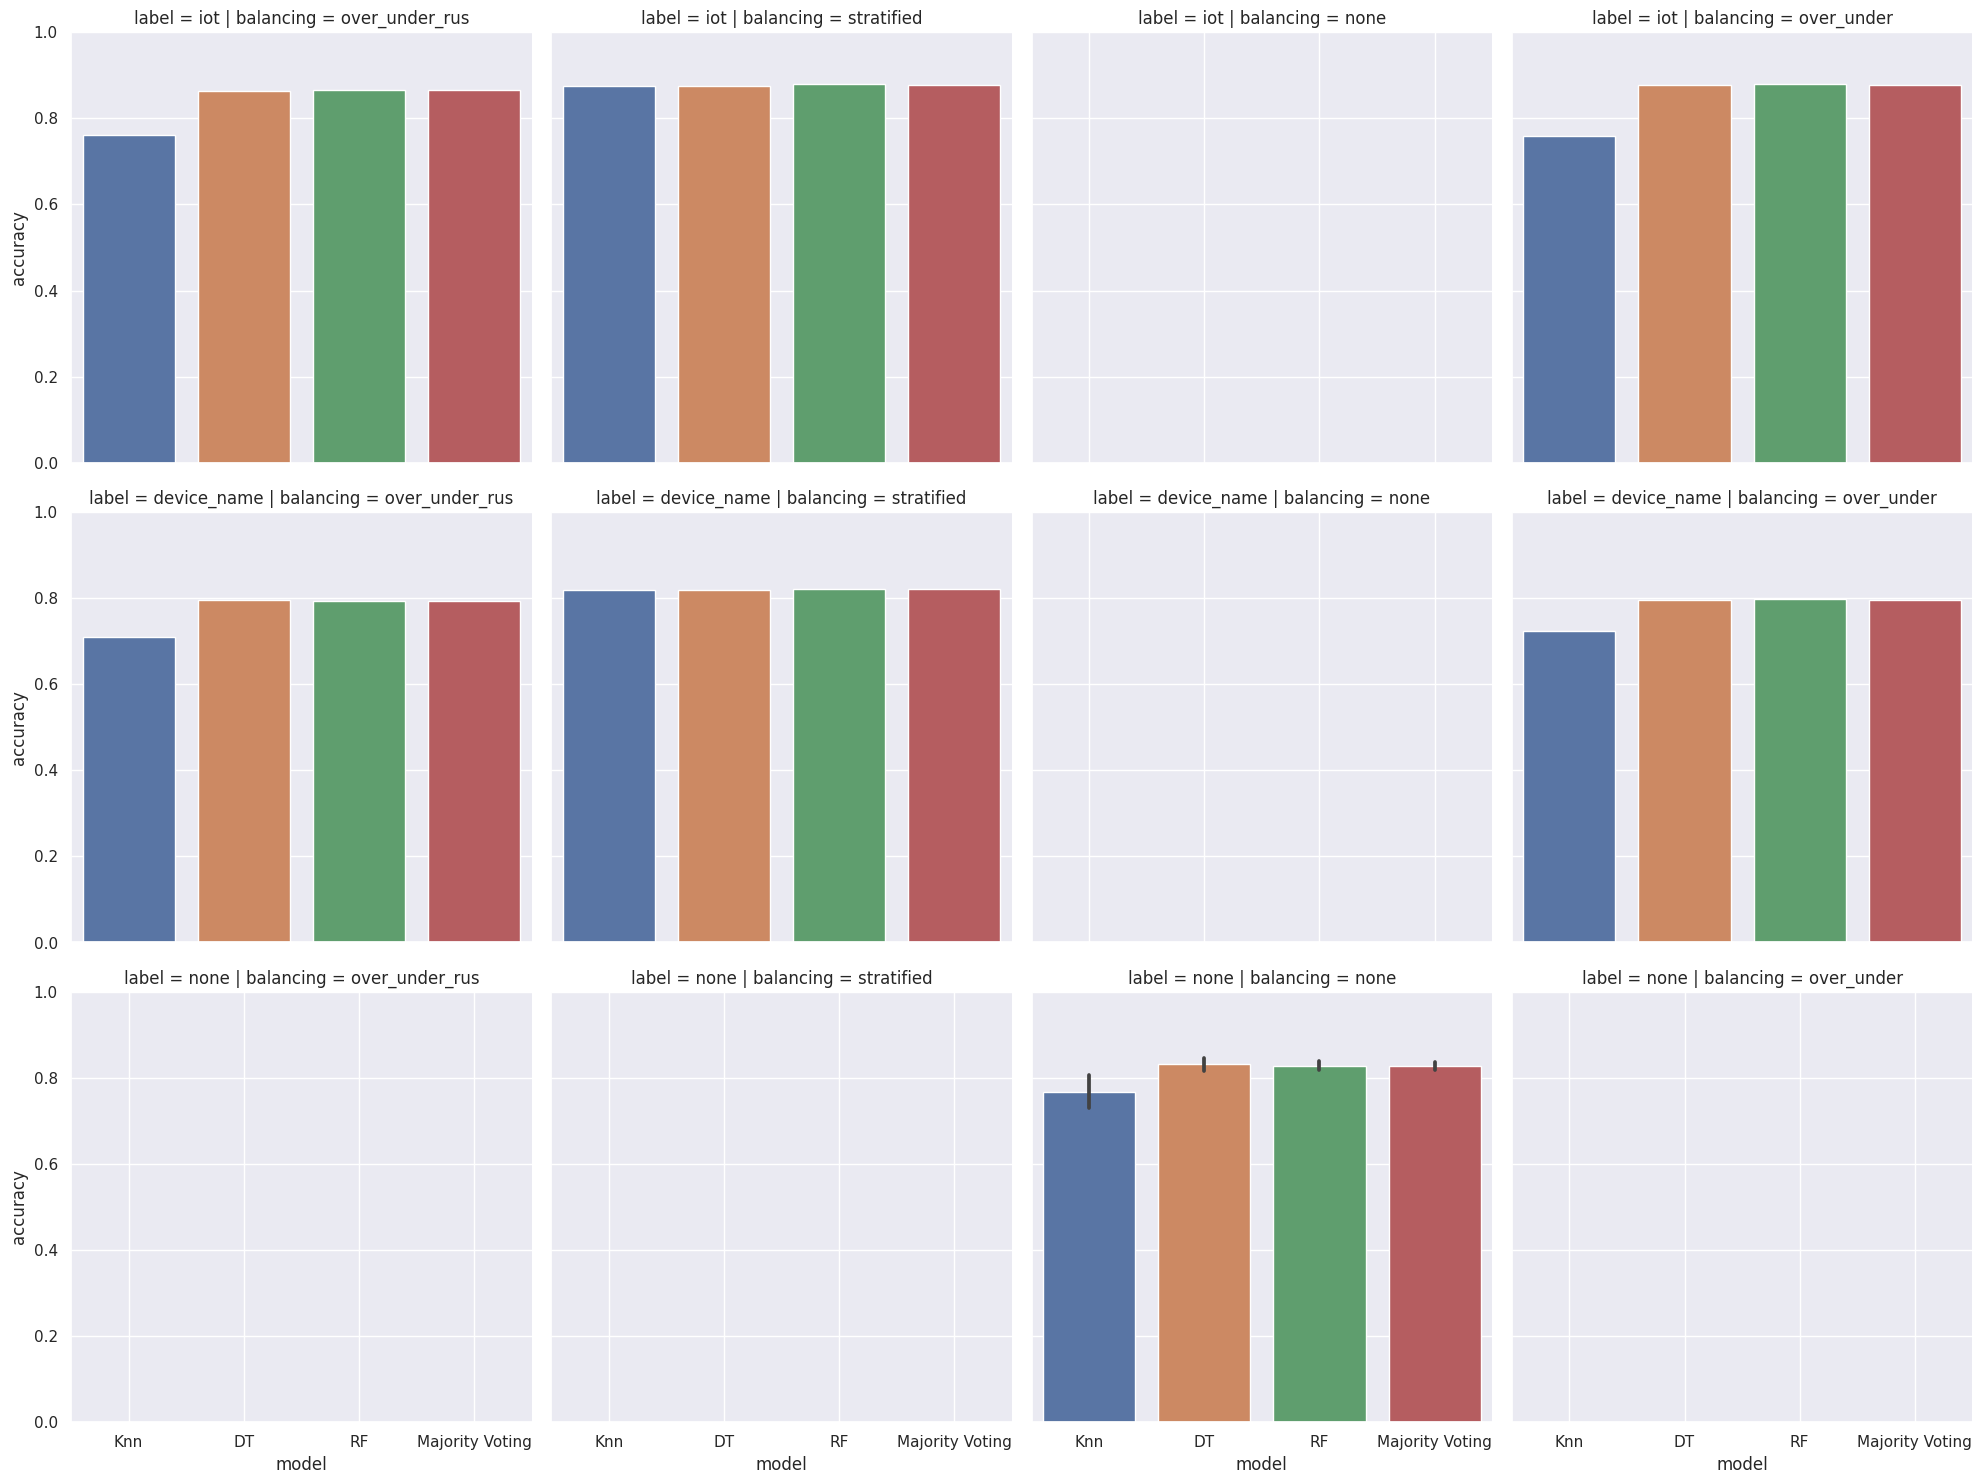

In [44]:
def draw_performance_plot(scores):
    sns.catplot(scores, x="model", y="accuracy", kind="bar")
    plt.ylim(0, 1)

def draw_multiple_perf(scores):
    assert "balancing" in scores.columns

    sns.catplot(scores, x="model", y="accuracy", col="balancing", row="label", kind="bar")
    plt.ylim(0, 1)

draw_multiple_perf(all_scores)
draw_multiple_perf(all_scores_tuned)

In [3]:
from sklearn import metrics

def test_realistic(iot_classifier, device_classifier, unlabeled_features, devices_in_window):
    assert len(unlabeled_features) == len(devices_in_window)

    # accuracy = metrics.accuracy_score(devices_in_window, iot_classifier.predict(unlabeled_features))
    accuracy = metrics.accuracy_score(devices_in_window, device_classifier.predict(unlabeled_features))
    print("Accuracy:", accuracy)
 

unlabeled_features = generate_features(windowed_frame)
devices_in_window = get_devices_in_window(windowed_frame)

test_realistic(iot_classifier, device_classifier, unlabeled_features, devices_in_window)

NameError: name 'generate_features' is not defined